# Introdução

Este notebook é uma introdução ao sistema de Yolo (You Only Look Once) utilzando a biblioteca OpenCV. O Yolo é um sistema de detecção de objetos em imagens e vídeos em tempo real. O OpenCV é uma biblioteca de visão computacional que possui diversas funções para processamento de imagens e vídeos.

- Autor: Kauã Henrique Da Silva

## Objetivos

Este notebook tem como objetivo demonstrar o funcionamento do sistema de Yolo utilizando a biblioteca OpenCV.


## Conteúdo

- Importando as bibliotecas necessárias; 
- Download de arquivos do Drive;
- Carregando o modelo Yolo;


# Setup

Pré requisitos para execução do notebook.

## Bibliotecas

Importando as bibliotecas necessárias para execução do notebook.

In [7]:
import cv2
import numpy as np
import matplotlib
import glob
import os
import shutil
import zipfile
import tempfile
import math

In [8]:
cv2.__version__, np.__version__, matplotlib.__version__

('4.10.0', '1.26.4', '3.8.0')

In [9]:
from matplotlib import pyplot as plt

## Download files from Drive

Download dos arquivos necessários para execução do notebook, o download é feito através do drive. Caso não consiga baixar os arquivos, você pode baixar manualmente através do link do
drive disponibilizado na célula abaixo

In [3]:
# @markdown #### Caso escolheu o tipo de recuperação drive/ambos e não tenha os arquivos, faça um atalho desse drive:
link_do_drive = "https://drive.google.com/drive/folders/18tvYFzTgoFyEjiHlfcT3rHxtOZdR3k9l?usp=drive_link" #@param {type:"string"}
path_atalho_drive = "/content/drive/MyDrive/Projetos Do GitHub/temp" #@param {type:"string"}
path_download = "temp" #@param {type:"string"}

In [11]:
if os.path.exists('python_download_file_drive'):
  print("Repositório já existe, fazendo pull")
  !cd python_download_file_drive && git pull
else:
  print("Repositório não existe, clonando!")
  !git clone https://github.com/KauaHenSilva/python_download_file_drive
%pip install --upgrade --quiet -r python_download_file_drive/requirements.txt

try:
    from google.colab import drive
    from google.colab import auth
    auth.authenticate_user()

    !python "python_download_file_drive/main.py" {link_do_drive} {path_download} # ALERTA: Caso o drive bote limite de download comente essa linha

    drive.mount('/content/drive')
    if not os.path.exists(path_atalho_drive):
      print("[INFO] Atalho no drive não encontrado.")

except:

    if os.path.exists(f"{path_download}.zip"):
      with tempfile.TemporaryDirectory() as tmpdirname:
        shutil.move(f"{path_download}.zip", tmpdirname)
        with zipfile.ZipFile(f"{tmpdirname}/{path_download}.zip", 'r') as zip_ref:
          zip_ref.extractall()

    if not os.path.exists(path_download):
      raise Exception(f"Você não está nos altenticado nos servidores do google colab. Para prosseguir, faça o download dos arquivos que estão presente no drive e tente novamente. O link do drive {link_do_drive}. A pasta deve está dentro de /content/")

Repositório já existe, fazendo pull
Already up to date.


## Descompactando arquivo YOLO

O modelo YOLO é baixado compactado, então é necessário descompactar o arquivo para utilizá-lo.

In [12]:
if os.path.exists(f"{path_download}/modelo_YOLOv4.zip"):
  with tempfile.TemporaryDirectory() as tmp_dir:
    shutil.move(f"{path_download}/modelo_YOLOv4.zip", f"{tmp_dir}/modelo_YOLOv4.zip")
    with zipfile.ZipFile(f"{tmp_dir}/modelo_YOLOv4.zip", 'r') as zip_ref:
      zip_ref.extractall(f"{path_download}/modelo_YOLOv4")

# Load Image

Carregando as imagens que serão utilizadas para teste do modelo YOLO juntamente com a função de exibição das imagens.

In [ ]:
with open(labels_path, 'r') as f:
  labels = f.read().splitlines()
labels[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [ ]:
imagens_path = glob.glob(f"{path_download}/imagens/*.jpg")
imagens_path

['temp/imagens/cachorro_gato.jpg',
 'temp/imagens/cachorros.jpg',
 'temp/imagens/img-canecas.jpg',
 'temp/imagens/caneca01.jpg',
 'temp/imagens/apple.jpg',
 'temp/imagens/cachorros02.jpg']

In [ ]:
def show_image(*image, figsize=(10, 10), qtd_col=1):
    fig = plt.figure(figsize=figsize)
    qtd_row = math.ceil(len(image) / qtd_col)
    
    for i, img in enumerate(image):
        ax = fig.add_subplot(qtd_row, qtd_col, i + 1)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        
    plt.show()

# Configurando YOLO

Configuração do YOLO, carregando o modelo e definindo as classes que o modelo é capaz de detectar.

Os paths abaixo são dos pesos, configuração e classes do modelo YOLO. Respectivamente.

In [4]:
weights_path = f"{path_download}/modelo_YOLOv4/yolov4.weights"
config_path = f"{path_download}/modelo_YOLOv4/cfg/yolov4.cfg"
labels_path = f"{path_download}/modelo_YOLOv4/cfg/coco.names"

In [ ]:
COLORS = np.random.randint(0, 255, size=(len(labels), 3))
COLORS[:5]

array([[180, 101, 238],
       [223,  70,  14],
       [102, 247, 157],
       [ 81,  64, 150],
       [108,  60, 176]])

A biblioteca OpenCV possui uma função que carrega o modelo YOLO, a função `cv2.dnn.readNet` é utilizada para carregar o modelo YOLO. O modelo YOLO é composto por dois arquivos, um arquivo `.cfg` que contém a arquitetura da rede neural e um arquivo `.weights` que contém os pesos da rede neural.

In [ ]:
net = cv2.dnn.readNet(config_path, weights_path)
ln = net.getLayerNames()
ln_out = net.getUnconnectedOutLayers()
ln_out_names = [ln[i - 1] for i in ln_out]
ln_out, ln_out_names

(array([327, 353, 379], dtype=int32), ['yolo_139', 'yolo_150', 'yolo_161'])

# Predição

In [ ]:
%%time
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
layer_outputs = net.forward(ln_out_names)

CPU times: user 2.94 s, sys: 6.16 s, total: 9.1 s
Wall time: 6.01 s


In [ ]:
treshold = 0.5
treshold_nms = 0.3

image = image_copy.copy()
H, W = image.shape[:2]

caixas = []
confiancas = []
IDclasses = []

for output in layer_outputs:
  
  for detection in output:
    scores = detection[5:]
    classeID = np.argmax(scores)
    confianca = scores[classeID]
    
    if confianca > treshold:
      caixa = detection[:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = caixa.astype("int")
      
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))
      
      caixas.append([x, y, width, height])
      confiancas.append(float(confianca))
      IDclasses.append(classeID)
      
print(f"Quantidade de caixas: {len(caixas)}")
print(f"Quantidade de confianças: {len(confiancas)}")
print(f"Quantidade de IDclasses: {len(IDclasses)}")

Classe: dog, Confiança: 0.6059548854827881
Classe: dog, Confiança: 0.9570456743240356
Classe: dog, Confiança: 0.889125406742096
Classe: dog, Confiança: 0.9090498685836792
Classe: dog, Confiança: 0.9525650143623352
Classe: dog, Confiança: 0.7894679307937622
Classe: dog, Confiança: 0.9860403537750244
Classe: dog, Confiança: 0.9869317412376404
Classe: dog, Confiança: 0.6623756885528564
Classe: dog, Confiança: 0.6959598064422607
Classe: dog, Confiança: 0.9729039072990417
Classe: dog, Confiança: 0.9767161011695862
Classe: dog, Confiança: 0.8875229358673096
Classe: dog, Confiança: 0.8976888060569763
Classe: dog, Confiança: 0.9810120463371277
Classe: dog, Confiança: 0.9824249744415283


In [ ]:
objects = cv2.dnn.NMSBoxes(caixas, confiancas, treshold, treshold_nms)
print(f"Quantidade de objetos: {len(objects)}")
print(f"Objetos selecionados: {objects.flatten()}")

array([ 7, 15, 11], dtype=int32)

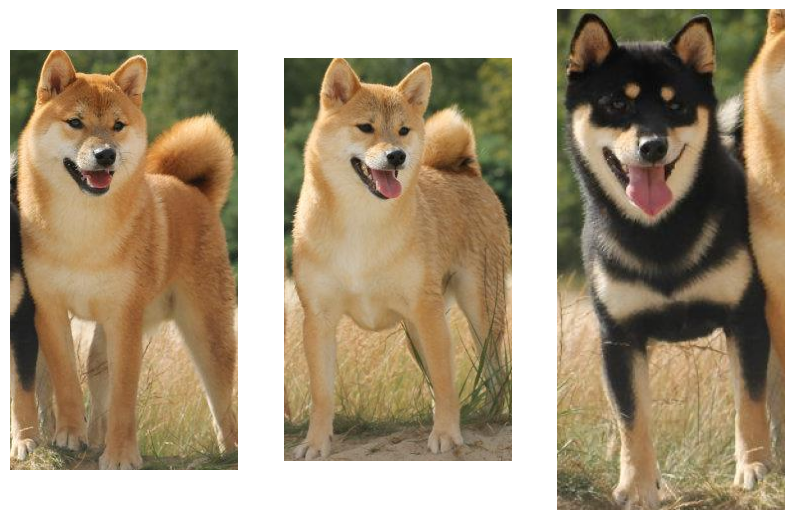

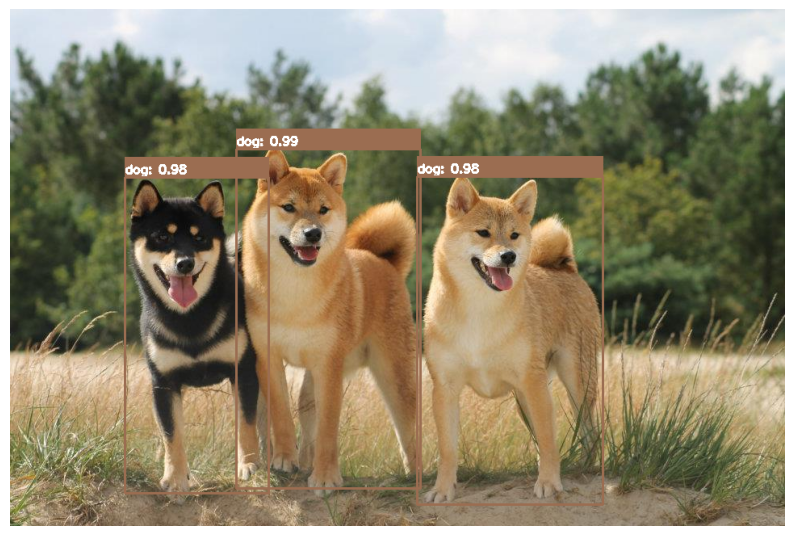

In [ ]:
objs_recort = []

for i in objects:
  color = COLORS[IDclasses[i]].tolist()
  text = f"{labels[IDclasses[i]]}: {confiancas[i]:.2f}"
  (x, y, w, h) = caixas[i]
  
  objs_recort.append(image_copy[y:y+h, x:x + w].copy())
  cv2.rectangle(image, (x, y - 25), (x + w, y), color, -1)
  cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
  cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

show_image(*objs_recort, qtd_col=3)
show_image(image)

## predic using function

Funções facilitadoras para predição de imagens utilizando o modelo YOLO.

### Função func_net_predic
O func_net_predic é uma função que realiza a predição de uma iamagem utilizando o modelo YOLO.

In [ ]:
def func_net_predic(net, ln_out_names, imagem, treshold=0.5):
  blob = cv2.dnn.blobFromImage(imagem, 1 / 255.0, (416, 416), swapRB=True, crop=False)
  net.setInput(blob)
  layer_outputs =  net.forward(ln_out_names)
  
  caixas = []
  confiancas = []
  id_classes = []
  
  H, W = imagem.shape[:2]
  
  for output in layer_outputs:
    for detection in output:
      scores = detection[5:]
      classeID = np.argmax(scores)
      confianca_ac = scores[classeID]
      
      if confianca_ac > treshold:
        caixa = detection[:4] * np.array([W, H, W, H])
        (centerX, centerY, width, height) = caixa.astype("int")
        
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))
        
        caixas.append([x, y, width, height])
        confiancas.append(float(confianca_ac))
        id_classes.append(classeID)

  return caixas, confiancas, id_classes

### Função func_net_predic

A função Func_net_predic recebe a predição do modelo YOLO é retorna a imagem com as caixas delimitadoras e as classes detectadas.

In [ ]:
def func_net_processing(caixas, confiancas, id_classes, labels, colors, treshold, treshold_nms, imagem):
  image_recort = imagem.copy()
  image_bbox = imagem.copy()
  
  objects = cv2.dnn.NMSBoxes(caixas, confiancas, treshold, treshold_nms)
  objs_recort = []
  
  for bbox_choice in objects:
    (x, y, w, h) = caixas[bbox_choice]
    color = colors[id_classes[bbox_choice]].tolist()
    text = f"{labels[id_classes[bbox_choice]]}: {confiancas[bbox_choice]:.2f}"
    
    fundo = np.full((imagem.shape), (0, 0, 0), dtype=np.uint8)
    cv2.putText(fundo, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    fx, fy, fw, fh = cv2.boundingRect(fundo[:, :, 2])
    
    cv2.rectangle(image_bbox, (x, y), (x + w, y + h), color, 2)
    cv2.rectangle(image_bbox, (fx, fy), (fx + fw, fy + fh), color, -1)
    cv2.rectangle(image_bbox, (fx, fy), (fx + fw, fy + fh), color, 3)
    cv2.putText(image_bbox, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    objs_recort.append(image_recort[y:y+h, x:x + w])
  return objs_recort, image_bbox

## Unitario

Detecção de objetos em uma única imagem.

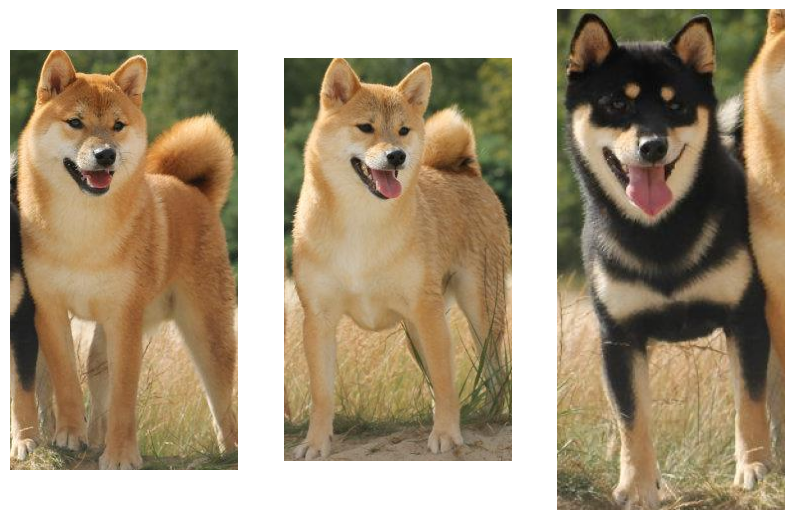

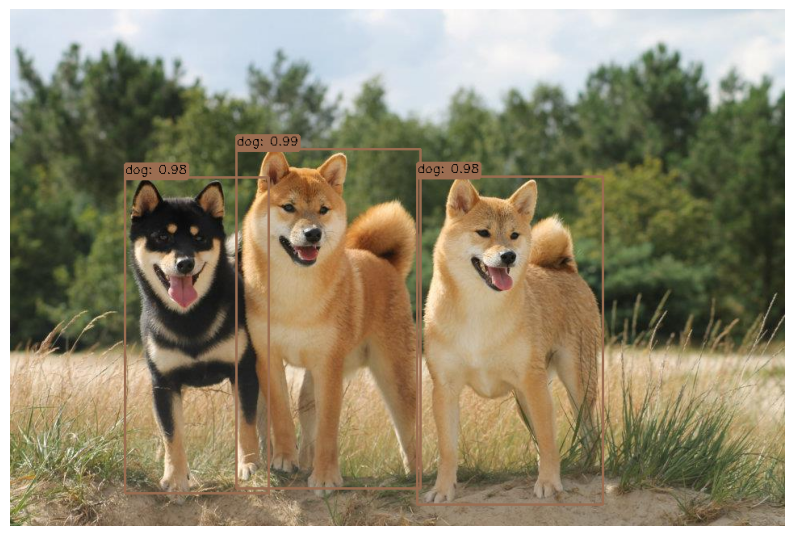

In [ ]:
treshold = 0.5
treshold_nms = 0.3

caixas, confiancas, IDclasses = func_net_predic(net, ln_out_names, image_copy)
imgs_proc, imgs_recort = func_net_processing(caixas, confiancas, IDclasses, labels, COLORS, treshold, treshold_nms, image_copy)

show_image(*imgs_proc, qtd_col=3)
show_image(imgs_recort)

## Mult Object

Detecção de objetos em várias imagens.

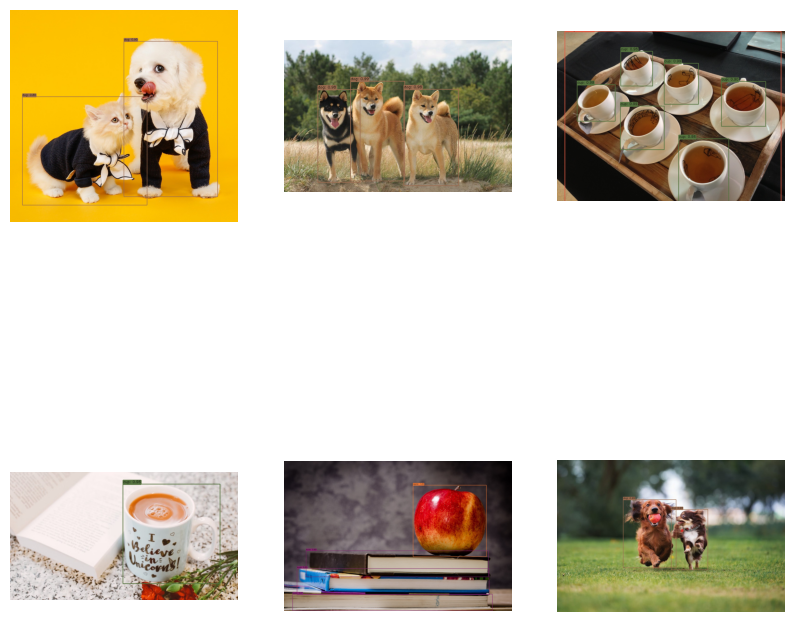

In [ ]:
imagens = [cv2.imread(img) for img in imagens_path]
imagens_copy = [img.copy() for img in imagens]

treshold = 0.5
treshold_nms = 0.3

imgs_proc_list = []
imgs_recort_list = []

for imagem in imagens_copy:
  caixas, confiancas, IDclasses = func_net_predic(net, ln_out_names, imagem)
  imgs_recort, imgs_proc = func_net_processing(caixas, confiancas, IDclasses, labels, COLORS, treshold, treshold_nms, imagem)
  imgs_proc_list.append(imgs_proc)
  imgs_recort_list.append(imgs_recort)

show_image(*imgs_proc_list, qtd_col=3)